In [1]:
%cd C:\Users\anash\Downloads\mnist

c:\Users\anash\Downloads\mnist


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import math

In [3]:
def LeNet5v2(input_shape = (28, 28, 1), classes = 10):
    """
    Implementation of a modified LeNet-5.
    Only those layers with learnable parameters are counted in the layer numbering.
    
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    model = Sequential([
        
    # Layer 1
    Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (28,28,1), kernel_regularizer=l2(0.0005), name = 'convolution_1'),
    # Layer 2
    Conv2D(filters = 32, kernel_size = 5, strides = 1, name = 'convolution_2', use_bias=False),
    # Layer 3    
    BatchNormalization(name = 'batchnorm_1'),
    # -------------------------------- #  
    Activation("relu"),
    MaxPooling2D(pool_size = 2, strides = 2, name = 'max_pool_1'),
    Dropout(0.25, name = 'dropout_1'),
    # -------------------------------- #  
    # Layer 3
    Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=l2(0.0005), name = 'convolution_3'),
    # Layer 4
    Conv2D(filters = 64, kernel_size = 3, strides = 1, name = 'convolution_4', use_bias=False),
    # Layer 5
    BatchNormalization(name = 'batchnorm_2'),
    # -------------------------------- #  
    Activation("relu"),
    MaxPooling2D(pool_size = 2, strides = 2, name = 'max_pool_2'),
    Dropout(0.25, name = 'dropout_2'),
    Flatten(name = 'flatten'),
    # -------------------------------- #  
    # Layer 6
    Dense(units = 256, name = 'fully_connected_1', use_bias=False),
    # Layer 7
    BatchNormalization(name = 'batchnorm_3'),   
    # -------------------------------- #  
    Activation("relu"),
    # -------------------------------- #  
    # Layer 8
    Dense(units = 128, name = 'fully_connected_2', use_bias=False),
    # Layer 9
    BatchNormalization(name = 'batchnorm_4'), 
    # -------------------------------- #  
    Activation("relu"),
    # -------------------------------- #  
    # Layer 10
    Dense(units = 84, name = 'fully_connected_3', use_bias=False),
    # Layer 11
    BatchNormalization(name = 'batchnorm_5'),
    # -------------------------------- #  
    Activation("relu"),
    Dropout(0.25, name = 'dropout_3'),
    # -------------------------------- #  

    # Output
    Dense(units = 10, activation = 'softmax', name = 'output')
        
    ])
    
    model._name = 'LeNet5v2'

    return model

In [5]:
LeNet5Model = LeNet5v2(input_shape = (28, 28, 1), classes = 10)
LeNet5Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Size of Dataset:  42000
Size of Cross Validation Set:  2100


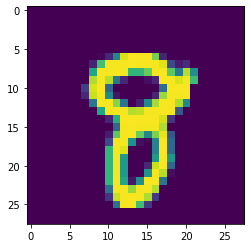

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Y = train[['label']]
X = train.drop(train.columns[[0]], axis=1)

X = X.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

print("Size of Dataset: " , len(X))

cross_validation_size = int(len(X)*0.05)


print("Size of Cross Validation Set: " , cross_validation_size)

random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = cross_validation_size, random_state=random_seed)

X_test = test

plt.imshow(X_train[0][:,:,0])

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Padding the images by 2 pixels since in the paper input images were 32x32
# this is not necessarily equivalent
#X_train =  np.array([ cv2.resize(x, (32,32)).reshape(32,32,1) for x in X_train])
#X_val = np.array([ cv2.resize(x, (32,32)).reshape(32,32,1) for x in X_val])
#X_test =  np.array([ cv2.resize(x, (32,32)).reshape(32,32,1) for x in X_test])
#X_train = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
#X_val = np.pad(X_val, ((0,0),(2,2),(2,2),(0,0)), 'constant')
#X_test = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

# Standardization
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)
X_train = (X_train - mean_px)/(std_px)

mean_px = X_val.mean().astype(np.float32)
std_px = X_val.std().astype(np.float32)
X_val = (X_val - mean_px)/(std_px)

mean_px = X_test.mean().astype(np.float32)
std_px = X_test.std().astype(np.float32)
X_test = (X_test - mean_px)/(std_px)

# One-hot encoding the labels
Y_train = to_categorical(Y_train, num_classes = 10)
Y_val = to_categorical(Y_val, num_classes = 10)

In [7]:
import tensorflow.keras.backend as K

In [21]:
'''batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

class GaussianNoise(tf.keras.layers.Layer):

    
    def __init__(self, sigma, **kwargs):
        self.supports_masking = True
        self.sigma = sigma
        self.uses_learning_phase = True
        super(GaussianNoise, self).__init__(**kwargs)

    def call(self, x, mask=None):
        noise_x = x + K.random_normal(shape=K.shape(x),
                                      mean=0.,
                                      stddev=self.sigma)
        return tf.clip_by_value(noise_x, 0, 1)



data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomTranslation(0.28, 0.28, fill_mode="constant"),
  tf.keras.layers.RandomZoom((-0.38, 0), None, fill_mode="constant"),
  tf.keras.layers.RandomRotation(0.5),
  GaussianNoise(0.001)
])

#print('\n'.join([''.join([str(0 if k==0 else 1) for k in x]) for x in a]))
#data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomZoom(-1)]); res = data_augmentation(a.reshape(-1, 28, 28));print('\n'.join([''.join([str(0 if k==0 else 1) for k in x]) for x in a])),print('\n'),print('\n'.join([''.join([str(0 if k==0 else 1) for k in x]) for x in res[0].numpy()]))
def prepare(ds_x, ds_y, shuffle=False, augment=False):
  # Batch all datasets.

  ds = tf.data.Dataset.from_tensor_slices((ds_x, ds_y))


  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


train_ds = prepare(X_train, Y_train, shuffle=True, augment=True)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val))'''

In [8]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

class GaussianNoise(tf.keras.layers.Layer):

    
    def __init__(self, sigma, **kwargs):
        self.supports_masking = True
        self.sigma = sigma
        self.uses_learning_phase = True
        super(GaussianNoise, self).__init__(**kwargs)

    def call(self, x, mask=None):
        noise_x = x + K.random_normal(shape=K.shape(x),
                                      mean=0.,
                                      stddev=self.sigma)
        return tf.clip_by_value(noise_x, 0, 1)


data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomTranslation(0.18, 0.18, fill_mode="constant"),
  tf.keras.layers.RandomZoom((-0.1, 0), None, fill_mode="constant"),
  tf.keras.layers.RandomRotation(0.1, fill_mode='constant'),
  GaussianNoise(0.1)
])


td = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

td2=td.map(lambda x, y: (tf.cast(data_augmentation(x, training=True), tf.float64), y))
td = td.concatenate(td2)
td = td.shuffle(50000)
td = td.batch(16)

import tensorflow_datasets as tfds
'''
npd = tfds.as_numpy(td)
i=0
#display(a[0])
for a in npd:
    plt.imshow(np.array(data_augmentation(a[0].reshape(1,28,28,1))).reshape(28, 28))
    plt.show()
    i+=1
    if i==50: break'''

NameError: in user code:

    File "C:\Users\anash\AppData\Local\Temp\ipykernel_35232\3171501888.py", line 30, in None  *
        lambda x, y: (tf.cast(data_augmentation(x, training=True), tf.float64), y)
    File "C:\Users\anash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\anash\AppData\Local\Temp\__autograph_generated_filei5sk4cja.py", line 10, in tf__call
        noise_x = ag__.ld(x) + ag__.converted_call(ag__.ld(K).random_normal, (), dict(shape=ag__.converted_call(ag__.ld(K).shape, (ag__.ld(x),), None, fscope), mean=0.0, stddev=ag__.ld(self).sigma), fscope)

    NameError: Exception encountered when calling layer "gaussian_noise" (type GaussianNoise).
    
    in user code:
    
        File "C:\Users\anash\AppData\Local\Temp\ipykernel_35232\3171501888.py", line 14, in call  *
            noise_x = x + K.random_normal(shape=K.shape(x),
    
        NameError: name 'K' is not defined
    
    
    Call arguments received by layer "gaussian_noise" (type GaussianNoise):
      • x=tf.Tensor(shape=(28, 28, 1), dtype=float32)
      • mask=None


In [12]:
variable_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 2)
history = LeNet5Model.fit(td, epochs = 30, batch_size = 16, callbacks = [variable_learning_rate], validation_data = (X_val,Y_val))

Epoch 1/30
 798/4988 [===>..........................] - ETA: 2:05 - loss: 0.0534 - accuracy: 0.9883

KeyboardInterrupt: 

In [9]:
variable_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 2)
history = LeNet5Model.fit(td, epochs = 30, batch_size = 16, callbacks = [variable_learning_rate], validation_data = (X_val,Y_val))

Epoch 1/30
4988/4988 [==============================] - 157s 31ms/step - loss: 0.4210 - accuracy: 0.8780 - val_loss: 0.0971 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 2/30
4988/4988 [==============================] - 152s 30ms/step - loss: 0.2580 - accuracy: 0.9317 - val_loss: 0.0748 - val_accuracy: 0.9876 - lr: 0.0010
Epoch 3/30
4988/4988 [==============================] - 151s 30ms/step - loss: 0.2177 - accuracy: 0.9462 - val_loss: 0.1130 - val_accuracy: 0.9752 - lr: 0.0010
Epoch 4/30
4988/4988 [==============================] - 153s 30ms/step - loss: 0.2002 - accuracy: 0.9513 - val_loss: 0.0622 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 5/30
4988/4988 [==============================] - 152s 30ms/step - loss: 0.1863 - accuracy: 0.9550 - val_loss: 0.0622 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 6/30
4988/4988 [==============================] - 153s 30ms/step - loss: 0.1712 - accuracy: 0.9590 - val_loss: 0.0679 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 7/30
4988/4988 [==================

: 

: 

In [11]:
variable_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 2)
LeNet5Model.fit(X_train, Y_train, epochs = 1, batch_size = 16, callbacks = [variable_learning_rate], validation_data = (X_val,Y_val))
history = LeNet5Model.fit(td, epochs = 30, batch_size = 16, callbacks = [variable_learning_rate], validation_data = (X_val,Y_val))

2494/2494 [==============================] - 73s 29ms/step - loss: 0.2055 - accuracy: 0.9470 - val_loss: 0.0765 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 1/30
4988/4988 [==============================] - 147s 29ms/step - loss: 0.4198 - accuracy: 0.8791 - val_loss: 0.0762 - val_accuracy: 0.9857 - lr: 0.0010
Epoch 2/30
4988/4988 [==============================] - 180s 36ms/step - loss: 0.2585 - accuracy: 0.9324 - val_loss: 0.0707 - val_accuracy: 0.9895 - lr: 0.0010
Epoch 3/30
4988/4988 [==============================] - 159s 31ms/step - loss: 0.2167 - accuracy: 0.9464 - val_loss: 0.0636 - val_accuracy: 0.9886 - lr: 0.0010
Epoch 4/30
4988/4988 [==============================] - 162s 32ms/step - loss: 0.1972 - accuracy: 0.9512 - val_loss: 0.0632 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 5/30
4988/4988 [==============================] - 182s 36ms/step - loss: 0.1862 - accuracy: 0.9559 - val_loss: 0.0599 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 6/30
4988/4988 [==============================

In [13]:
LeNet5Model.evaluate(X_val, Y_val)

66/66 [==============================] - 0s 6ms/step - loss: 0.0239 - accuracy: 0.9952


[0.023890411481261253, 0.9952380657196045]

In [14]:
LeNet5Model.save("exported.h5")

In [15]:
LeNet5Model.save("lnet1")
!tar -cvf lnet1.tgz lnet1

INFO:tensorflow:Assets written to: lnet1\assets


INFO:tensorflow:Assets written to: lnet1\assets
a lnet1
a lnet1/assets
a lnet1/keras_metadata.pb
a lnet1/saved_model.pb
a lnet1/variables
a lnet1/variables/variables.data-00000-of-00001
a lnet1/variables/variables.index


: 

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

In [5]:
loadedLeNet5Model = tf.keras.models.load_model("exported.h5")

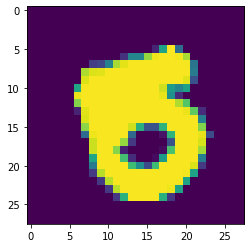

Actual 5
Guessed 8 
##########


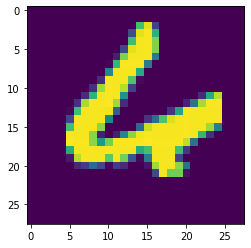

Actual 6
Guessed 4 
##########


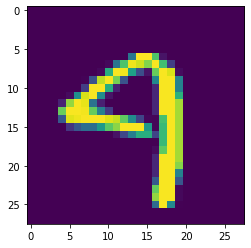

Actual 4
Guessed 9 
##########


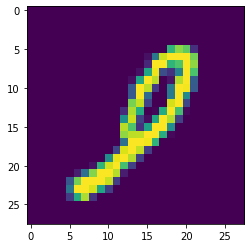

Actual 9
Guessed 8 
##########


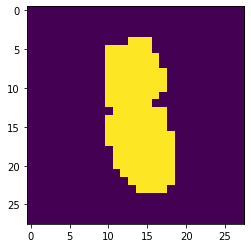

Actual 1
Guessed 8 
##########


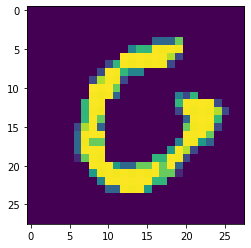

Actual 0
Guessed 6 
##########


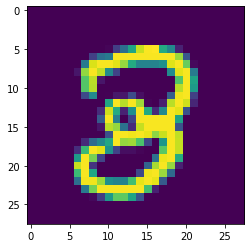

Actual 3
Guessed 8 
##########


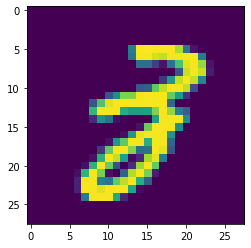

Actual 3
Guessed 8 
##########


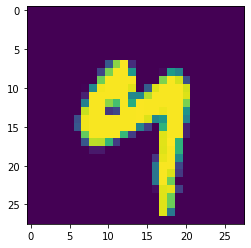

Actual 9
Guessed 4 
##########


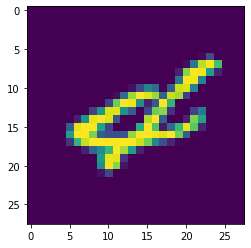

Actual 4
Guessed 2 
##########


In [11]:
results = np.array([np.argmax(loadedLeNet5Model(X_val[i].reshape(-1, 28, 28, 1)))==np.argmax(Y_val[i]) for i in range(len(X_val))])

for i in (np.where(results==False)[0]):
  plt.imshow(X_val[i].reshape(28,28))
  plt.show()
  print("Actual", np.argmax(Y_val[i]))
  print("Guessed", np.argmax(loadedLeNet5Model(X_val[i].reshape(-1, 28, 28, 1))), '\n##########')

4/4 [==============================] - 8s 2s/step


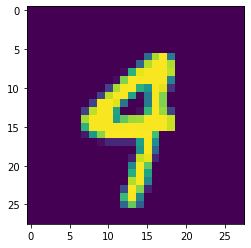

Actual 9
Guessed 4 
##########


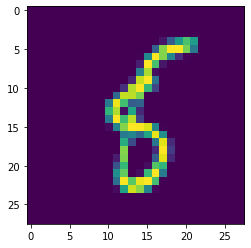

Actual 8
Guessed 5 
##########


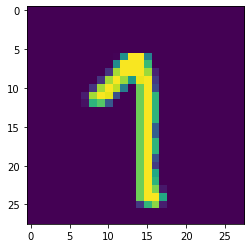

Actual 7
Guessed 1 
##########


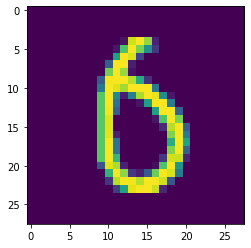

Actual 0
Guessed 6 
##########


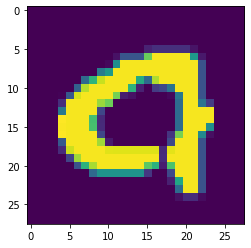

Actual 4
Guessed 9 
##########


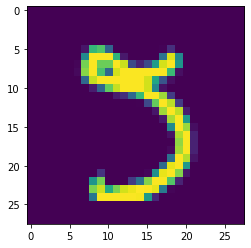

Actual 5
Guessed 3 
##########


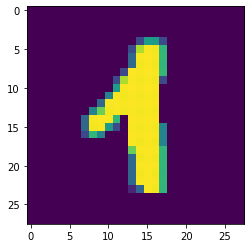

Actual 4
Guessed 1 
##########


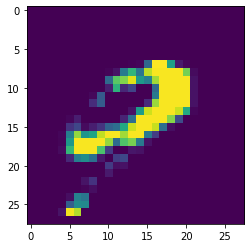

Actual 9
Guessed 2 
##########


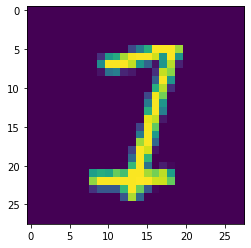

Actual 7
Guessed 1 
##########


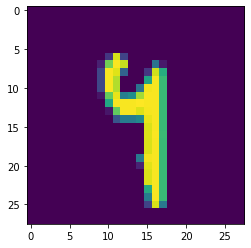

Actual 9
Guessed 4 
##########


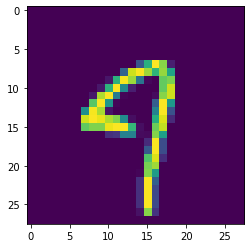

Actual 4
Guessed 9 
##########


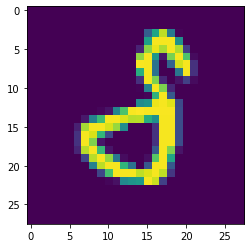

Actual 5
Guessed 8 
##########


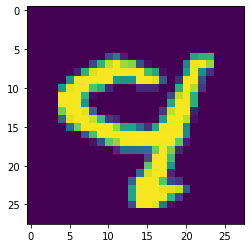

Actual 4
Guessed 9 
##########


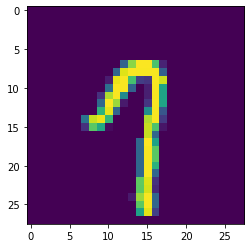

Actual 9
Guessed 7 
##########


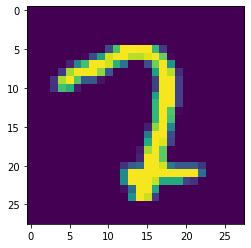

Actual 7
Guessed 2 
##########


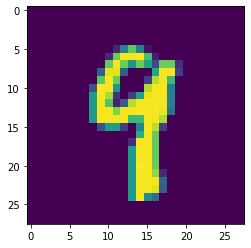

Actual 4
Guessed 9 
##########


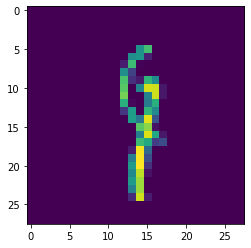

Actual 4
Guessed 9 
##########


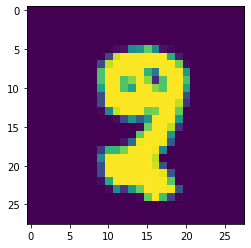

Actual 8
Guessed 9 
##########


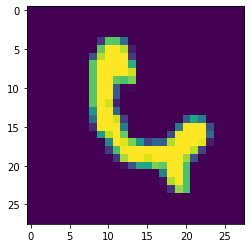

Actual 6
Guessed 4 
##########


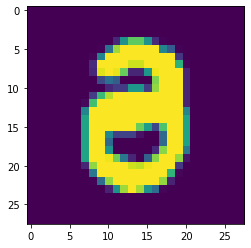

Actual 8
Guessed 3 
##########


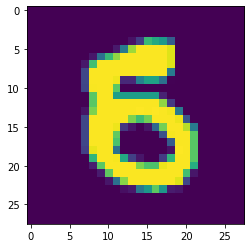

Actual 5
Guessed 6 
##########


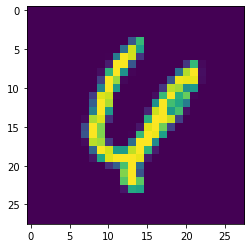

Actual 6
Guessed 4 
##########


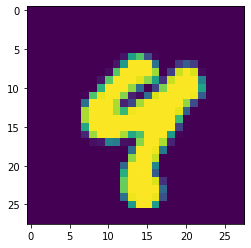

Actual 4
Guessed 9 
##########


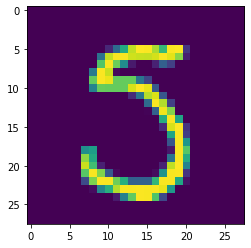

Actual 3
Guessed 5 
##########


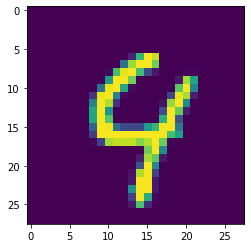

Actual 9
Guessed 4 
##########


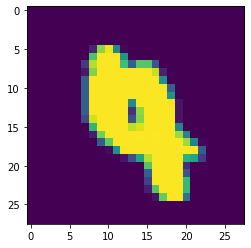

Actual 4
Guessed 9 
##########


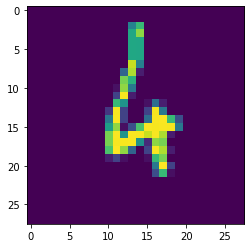

Actual 6
Guessed 4 
##########


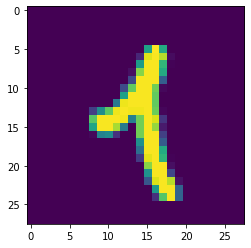

Actual 4
Guessed 1 
##########


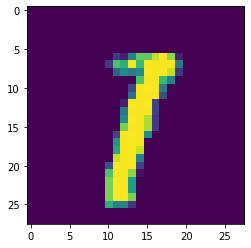

Actual 7
Guessed 1 
##########


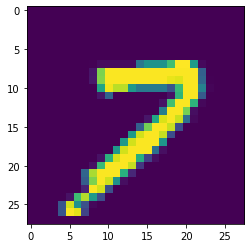

Actual 4
Guessed 7 
##########


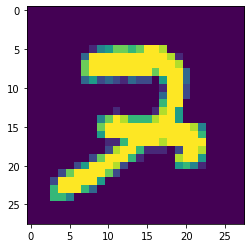

Actual 3
Guessed 7 
##########


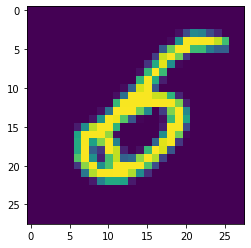

Actual 5
Guessed 6 
##########


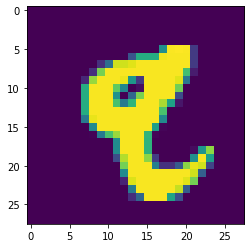

Actual 9
Guessed 8 
##########


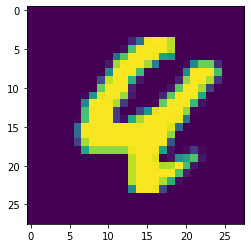

Actual 9
Guessed 4 
##########


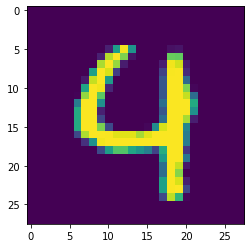

Actual 9
Guessed 4 
##########


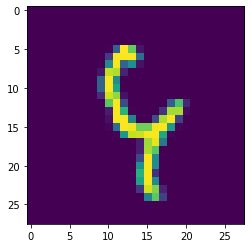

Actual 9
Guessed 4 
##########


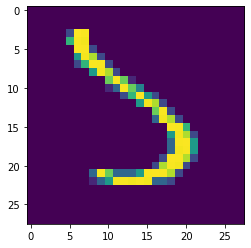

Actual 5
Guessed 7 
##########


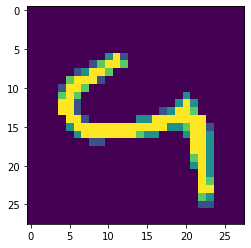

Actual 4
Guessed 9 
##########


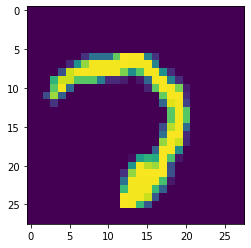

Actual 7
Guessed 2 
##########


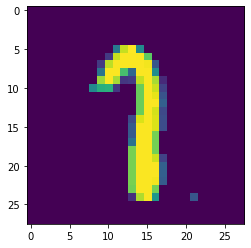

Actual 1
Guessed 7 
##########


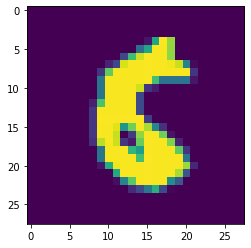

Actual 8
Guessed 6 
##########


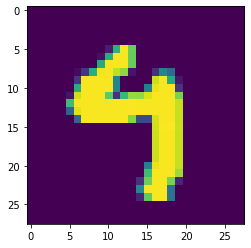

Actual 9
Guessed 4 
##########


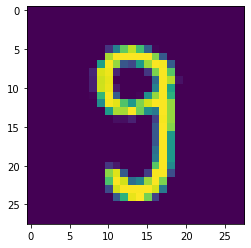

Actual 3
Guessed 9 
##########


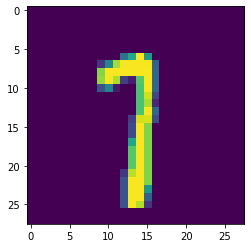

Actual 1
Guessed 7 
##########


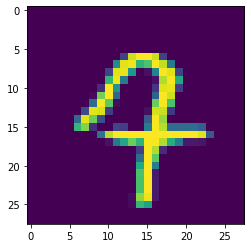

Actual 9
Guessed 7 
##########


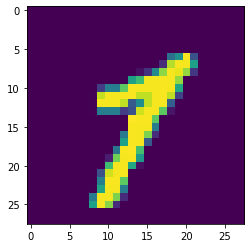

Actual 1
Guessed 7 
##########


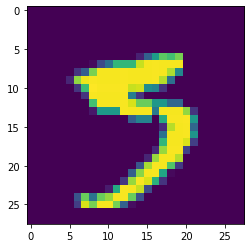

Actual 3
Guessed 5 
##########


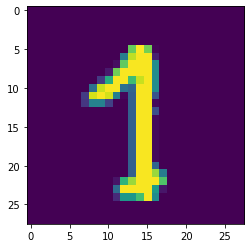

Actual 7
Guessed 1 
##########


In [12]:
res =  loadedLeNet5Model.predict(X_train, batch_size = 10000)
for i in np.where(np.argmax(Y_train, axis=1) != np.argmax(res, axis=1))[0]:
  plt.imshow(X_train[i].reshape(28,28))
  plt.show()
  print("Actual", np.argmax(Y_train[i]))
  print("Guessed", np.argmax(loadedLeNet5Model(X_train[i].reshape(-1, 28, 28, 1))), '\n##########')